In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
# Chargement des données
base_dir = "C:/Users/HP PAVILION/DatasetProject/"
img_height = 50  # La taille d'entrée de VGG-19
img_width = 50
batch_size = 32


In [3]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="both", 
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 41387 files belonging to 5 classes.
Using 33110 files for training.
Using 8277 files for validation.


In [4]:
# Création du modèle VGG-19 pré-entraîné
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [5]:
images_train, labels_train = next(iter(train_set))
images_test, labels_test = next(iter(test_set))

In [6]:
X_train = images_train.numpy()
X_test = images_test.numpy()

Y_train = labels_train.numpy()
Y_test = labels_test.numpy()

In [7]:
Y_test[Y_test != 1] = 0
Y_train[Y_train != 1] = 0

In [8]:
base_model.trainable = False

In [9]:
out = base_model.output
x = layers.Flatten()(out)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

In [10]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [12]:
import datetime

epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  
history = model.fit(X_train, Y_train, epochs=epochs,  validation_data=(X_test, Y_test),  callbacks=[early_stopping])

Epoch 1/10
1/1 [==============================] - 1s 636ms/step - loss: 1.5292 - accuracy: 0.6875 - val_loss: 0.7792 - val_accuracy: 0.6875
Epoch 2/10
1/1 [==============================] - 0s 468ms/step - loss: 2.1006 - accuracy: 0.5625 - val_loss: 0.7929 - val_accuracy: 0.7188
Epoch 3/10
1/1 [==============================] - 1s 539ms/step - loss: 0.7407 - accuracy: 0.7812 - val_loss: 0.8081 - val_accuracy: 0.7188
Epoch 4/10
1/1 [==============================] - 1s 558ms/step - loss: 1.6045 - accuracy: 0.6562 - val_loss: 0.8227 - val_accuracy: 0.7188
Epoch 5/10
1/1 [==============================] - 0s 449ms/step - loss: 1.5265 - accuracy: 0.6562 - val_loss: 0.8285 - val_accuracy: 0.7188
Epoch 6/10
1/1 [==============================] - 1s 562ms/step - loss: 1.5346 - accuracy: 0.6875 - val_loss: 0.8180 - val_accuracy: 0.7188


In [13]:
# save weights 
model.save_weights('./vgg19-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.5.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

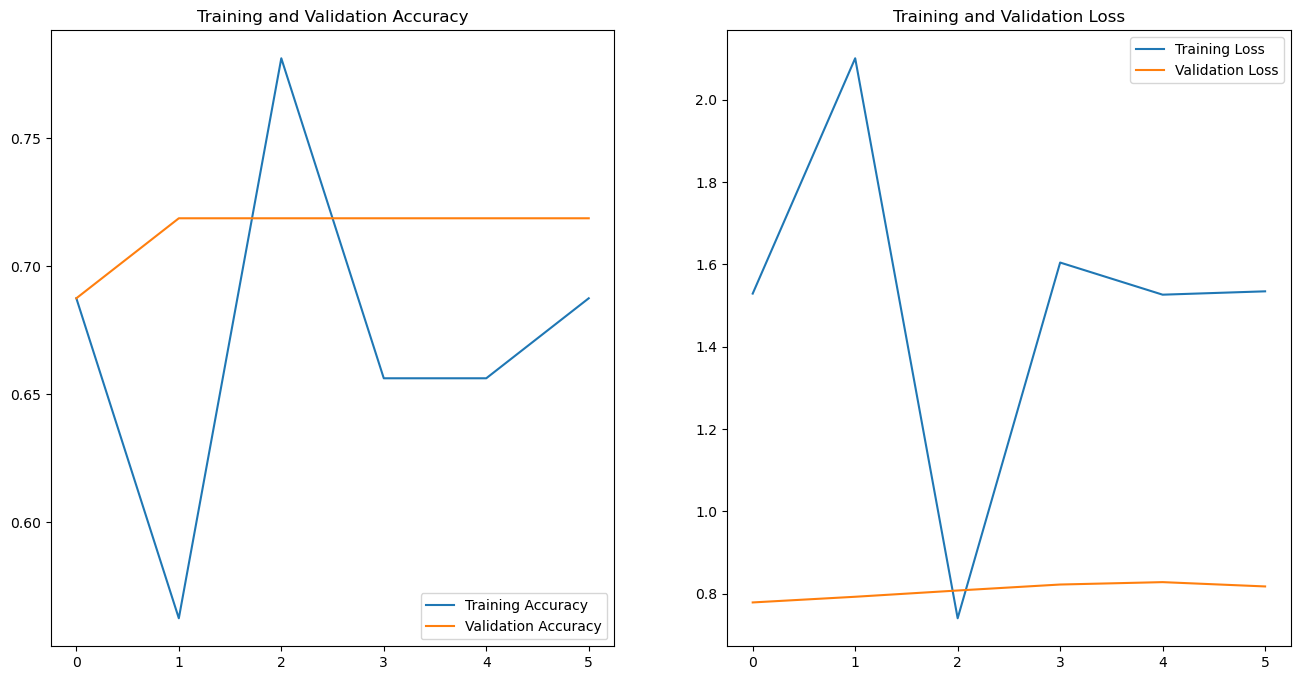

In [14]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(6), acc, label='Training Accuracy')
plt.plot(range(6), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(6), loss, label='Training Loss')
plt.plot(range(6), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(
    images_train,
    labels_train,
    batch_size=32,
)

val_generator = datagen.flow(
    images_test,
    labels_test,
    batch_size=32,
)

In [17]:
history_2 = model.fit(train_generator, epochs=epochs,  validation_data=val_generator,  callbacks=[early_stopping])
# save weights 
model.save_weights('./vgg19-with-data-augmentation-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.5.h5')

Epoch 1/10
1/1 [==============================] - 1s 564ms/step - loss: 0.6456 - accuracy: 0.2812 - val_loss: 0.5777 - val_accuracy: 0.2812
Epoch 2/10
1/1 [==============================] - 1s 565ms/step - loss: 0.6284 - accuracy: 0.2188 - val_loss: 0.5007 - val_accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - 1s 610ms/step - loss: 0.3200 - accuracy: 0.2812 - val_loss: 0.4089 - val_accuracy: 0.2500
Epoch 4/10
1/1 [==============================] - 1s 640ms/step - loss: 0.3135 - accuracy: 0.3125 - val_loss: 0.3506 - val_accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 1s 650ms/step - loss: 0.2523 - accuracy: 0.2812 - val_loss: 0.2530 - val_accuracy: 0.2500
Epoch 6/10
1/1 [==============================] - 1s 780ms/step - loss: 0.0543 - accuracy: 0.2812 - val_loss: 0.1847 - val_accuracy: 0.2500
Epoch 7/10
1/1 [==============================] - 1s 686ms/step - loss: -0.0234 - accuracy: 0.2812 - val_loss: 0.0789 - val_accuracy: 0.2500
Epoch 8/10
1/1 [===

In [18]:
from tensorflow.keras.applications import EfficientNetB0

In [19]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [20]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               1310976   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 5,426,596
Trainable params: 5,384,573
Non-

In [22]:
history_3 = model.fit(X_train, Y_train, epochs=epochs,  validation_data=(X_test, Y_test),  callbacks=[early_stopping])
# save weights 
model.save_weights('./efficientB0-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.5.h5')

Epoch 1/10
1/1 [==============================] - 15s 15s/step - loss: 0.6056 - accuracy: 0.7188 - val_loss: 0.5792 - val_accuracy: 0.7188
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.2679 - accuracy: 0.9062 - val_loss: 0.5530 - val_accuracy: 0.7188
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.1781 - accuracy: 0.9688 - val_loss: 0.5377 - val_accuracy: 0.7188
Epoch 4/10
1/1 [==============================] - 1s 934ms/step - loss: 0.0562 - accuracy: 1.0000 - val_loss: 0.5229 - val_accuracy: 0.7188
Epoch 5/10
1/1 [==============================] - 1s 991ms/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.5072 - val_accuracy: 0.7188
Epoch 6/10
1/1 [==============================] - 1s 766ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.5004 - val_accuracy: 0.7500
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.4989 - val_accuracy: 0.8125
Epoch 8/10
1/1 [==============

In [23]:
from tensorflow.keras.applications import EfficientNetB7
improve_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [24]:
model2 = Sequential()
model2.add(improve_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2, 2, 2560)       64097687  
                                                                 
 flatten_2 (Flatten)         (None, 10240)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               2621696   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66,719,640
Trainable params: 66,408,913
Non-trainable params: 310,727
_________________________________________________________________


In [26]:
history_4 = model2.fit(X_train, Y_train, epochs=epochs,  validation_data=(X_test, Y_test),  callbacks=[early_stopping])
# save weights 
model2.save_weights('./efficientB7-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.5.h5')

Epoch 1/10
1/1 [==============================] - 53s 53s/step - loss: 0.9401 - accuracy: 0.3750 - val_loss: 0.5894 - val_accuracy: 0.7500
Epoch 2/10
1/1 [==============================] - 11s 11s/step - loss: 0.7197 - accuracy: 0.7500 - val_loss: 0.8139 - val_accuracy: 0.7500
Epoch 3/10
1/1 [==============================] - 7s 7s/step - loss: 0.0936 - accuracy: 1.0000 - val_loss: 0.9806 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.0503 - accuracy: 0.9688 - val_loss: 1.0873 - val_accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.1794 - val_accuracy: 0.7500
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 5.0310e-04 - accuracy: 1.0000 - val_loss: 1.2602 - val_accuracy: 0.7500
